In [43]:
import os

import torch
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from torch.utils.data import DataLoader
from utils.ch_tokenizer import CharTokenizer
from datasets.text_dataset import TextDataset
from models.transformerLM import TransformerLanguageModel
from config import CHECKPOINT_PATH, TXT_FILE_PATH, SEQ_LEN, MODEL_CONFIG

In [44]:
def plot_attention_layer(attn_weights, tokens):

    num_layers = len(attn_weights)
    num_heads = attn_weights[0].size(1)
    
    fig, axs = plt.subplots(num_layers, num_heads, figsize=(3*num_heads, 3*num_layers))
    fig.suptitle("Attention Maps per Layer and Head", fontsize=16)
    
    for layer_idx, attn_tensor in enumerate(attn_weights):
        attn_tensor = attn_tensor.squeeze(0).cpu()
        
        for head_idx in range(num_heads):
            ax = axs[layer_idx, head_idx] if num_layers > 1 else axs[head_idx]
            sns.heatmap(attn_tensor[head_idx], xticklabels=tokens, yticklabels=tokens,
                        cmap="viridis", ax=ax, cbar=False)
            ax.set_title(f"L{layer_idx+1} H{head_idx+1}")
            ax.tick_params(axis='x', labelrotation=90)
            ax.set_xlabel("Key")
            ax.set_ylabel("Query")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [45]:
checkpoint_path = CHECKPOINT_PATH
txt_file_path = TXT_FILE_PATH

tokenizer = CharTokenizer(txt_file_path)
vocab_size = tokenizer.vocab_size

seq_len = SEQ_LEN
embed_dim = MODEL_CONFIG['embed_dim']
num_heads = MODEL_CONFIG['num_heads']
hidden_dim = MODEL_CONFIG['hidden_dim']
enc_ffn_h_dim = MODEL_CONFIG['enc_ffn_h_dim']
num_enc = MODEL_CONFIG['num_enc']
use_sinusoidal = MODEL_CONFIG['use_sinusoidal']

device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerLanguageModel(vocab_size, embed_dim, seq_len, hidden_dim, num_heads, enc_ffn_h_dim, num_enc, use_sinusoidal).to(device)

model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Visualize Training Loss, Validation Loss and Perplexity over the Epochs

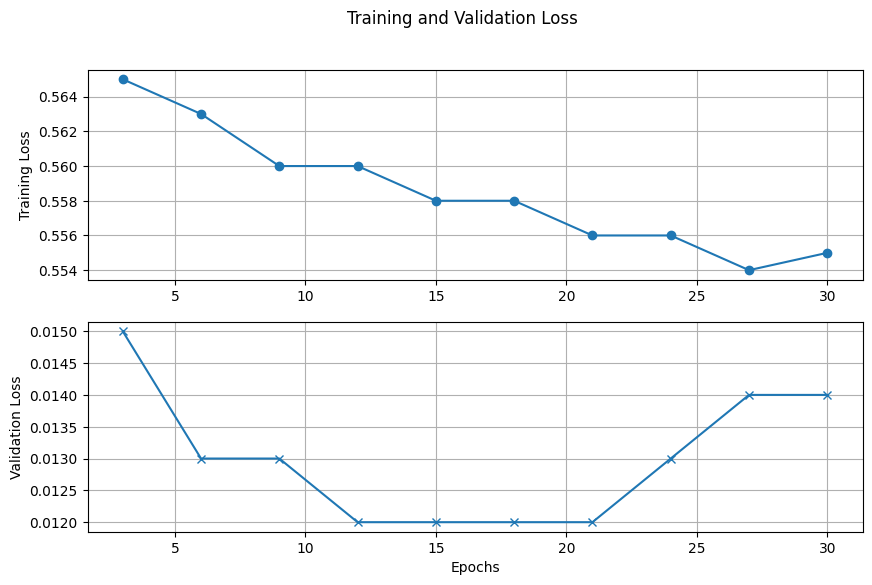

In [ ]:
training_info_path = os.path.relpath(os.path.join(os.path.dirname(CHECKPOINT_PATH), 'training_info.txt'))

epochs = []
train_loss = []
val_loss = []
perplexity = []

with open(training_info_path, 'r') as file:
    next(file)
    for line in file:
        content = line.strip().split(',')
        epochs.append(int(content[0]))
        train_loss.append(float(content[1]))
        val_loss.append(float(content[2]))
        perplexity.append(float(content[3]))

plt.figure(figsize=(10, 6))
plt.suptitle('Training Loss, Validation Loss and Perplexity')

plt.subplot(3, 1, 1)
plt.plot(epochs, train_loss, marker='o')
plt.ylabel('Training Loss')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(epochs, val_loss, marker='x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(epochs, perplexity, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Visualize Attention Weights

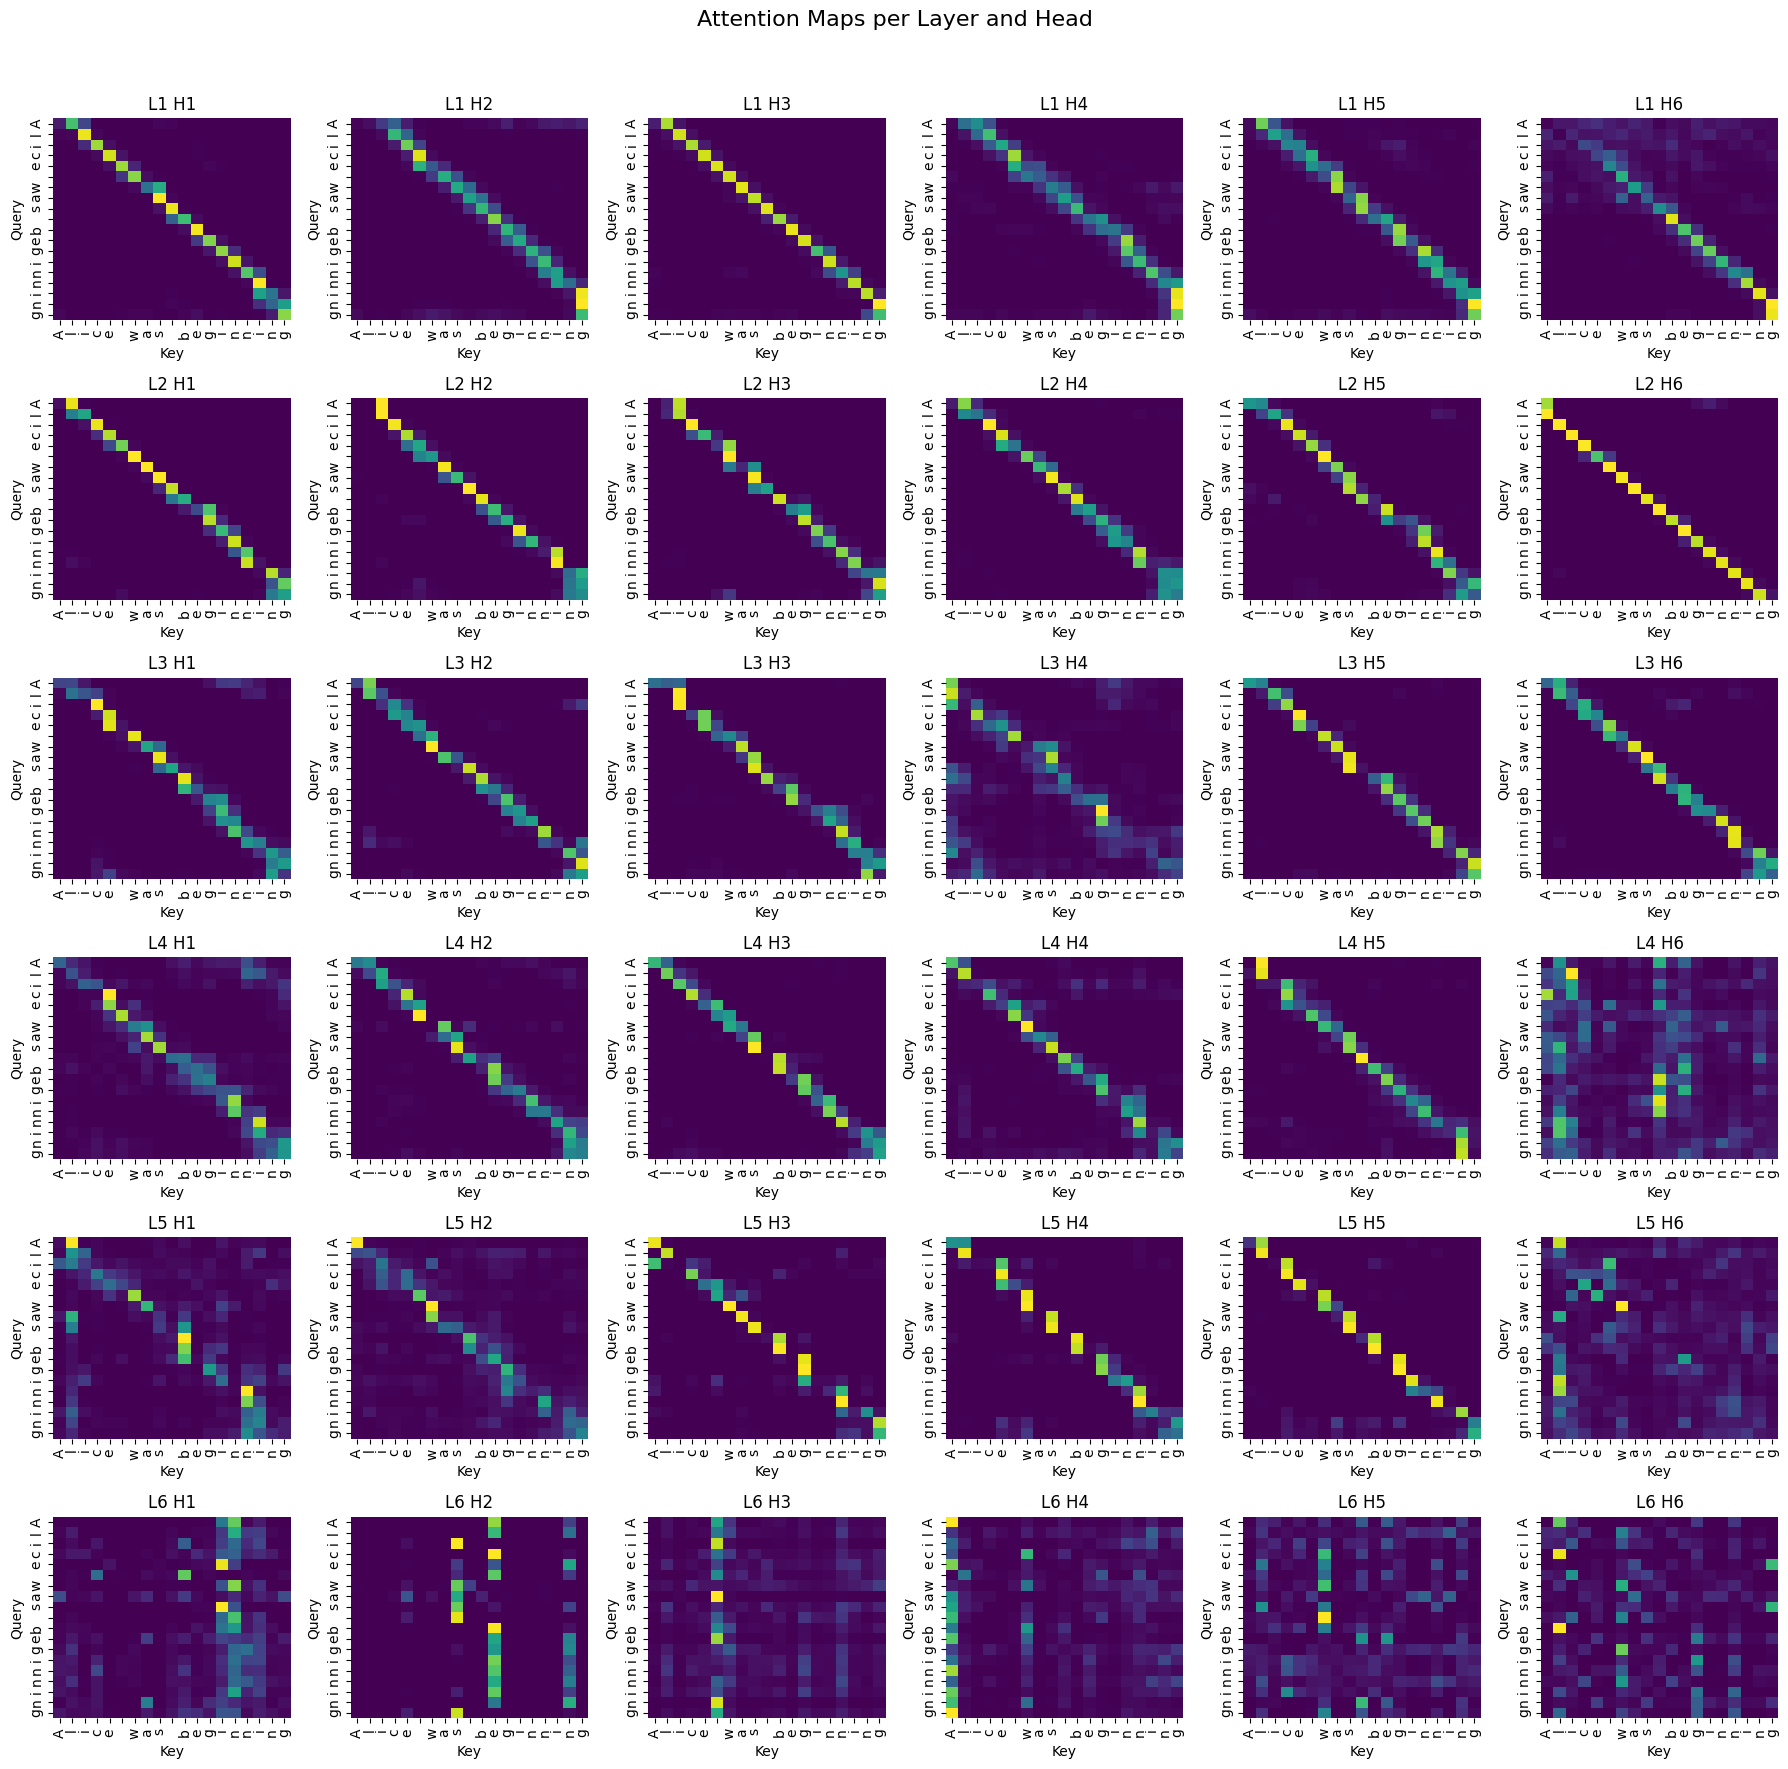

In [47]:
model.eval()

seed_text = "Alice was beginning"
input_tokens = tokenizer.encode(seed_text)

if len(input_tokens) > seq_len:
    input_tokens = torch.tensor(input_tokens[-seq_len:]).unsqueeze(0).to(device)
else:    
    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)

with torch.no_grad():
        pred_logits, attention_weights = model(input_tokens)

        tokens = tokenizer.decode(input_tokens[0].tolist())

        plot_attention_layer(attention_weights, tokens)